## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

In [1]:
# Imblearn libary is used to handle imbalanced data

# Jupyter notebook
#!pip install imblearn --user

#!pip install imbalanced-learn --user

## Importing necessary libraries

In [2]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# plt.style.use("seaborn-dark")  # this adds beauty to charts
sns.set(rc={"figure.figsize": (10, 6)})

<IPython.core.display.Javascript object>

## Loading the dataset

In [3]:
# Loading train and test data
df = pd.read_csv("Train_data.csv")
df_test = pd.read_csv("Test_data.csv")

<IPython.core.display.Javascript object>

In [4]:
# creating a copy of the training data
data = df.copy()

# creating a copy of the training data
data_test = df_test.copy()

<IPython.core.display.Javascript object>

## Data Overview

- Observations
- Sanity checks

In [5]:
# let's view the first 5 rows of the train data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


<IPython.core.display.Javascript object>

In [6]:
# let's view the first 5 rows of the test data
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


<IPython.core.display.Javascript object>

In [7]:
# Checking the number of rows and columns in the training data
data.shape

(20000, 41)

<IPython.core.display.Javascript object>

- There are 20,000 rows and 41 columns in the training data

In [8]:
# Checking the number of rows and columns in the testing data
data_test.shape

(5000, 41)

<IPython.core.display.Javascript object>

- There are 5,000 rows and 41 columns in the testing data

#### Checking the data types of the columns for the dataset

In [9]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

<IPython.core.display.Javascript object>

- All the columns are of numerical types
- There are no missing values in the dataset.

#### Checking for duplicate values

In [10]:
# let's check for duplicate values training in the data
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

- There are no dulicates in our training data

In [11]:
# let's check for duplicate values testing in the data
data_test.duplicated().sum()

0

<IPython.core.display.Javascript object>

- There are no dulicates in our test data

#### Checking for missing values

In [12]:
# let's check for missing values in the data
data.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

<IPython.core.display.Javascript object>

- Only the V1 and the V2 columns have missings data in the entire data set

### Statistical summary of the dataset

In [13]:
# viewing the statistical summary of the numerical columns in the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


<IPython.core.display.Javascript object>

## Exploratory Data Analysis (EDA)

## Univariate analysis

### Plotting histograms and boxplots for all the variables

In [14]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

### Plotting all the features at one go

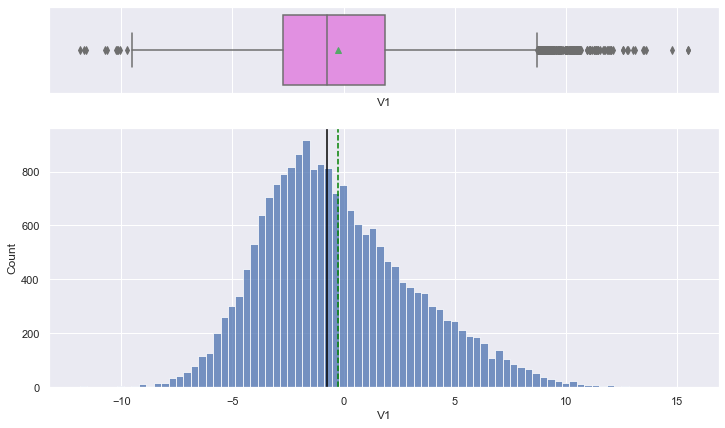

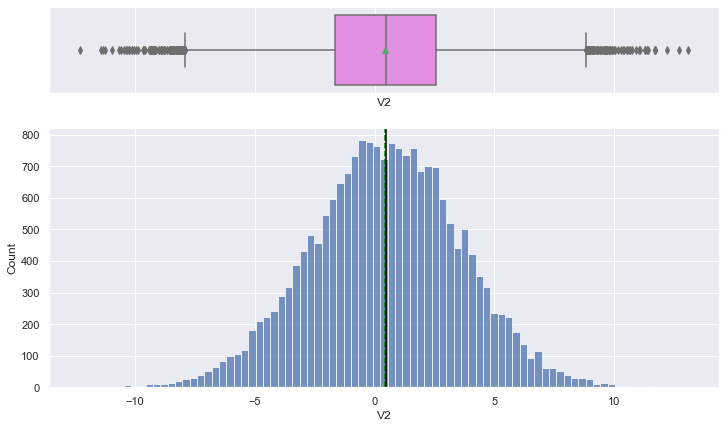

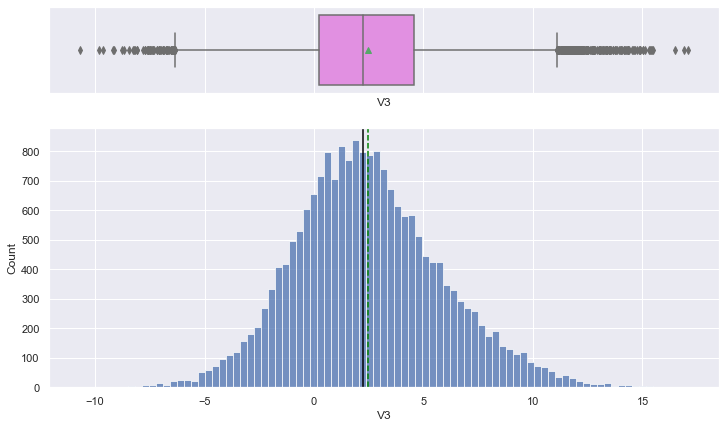

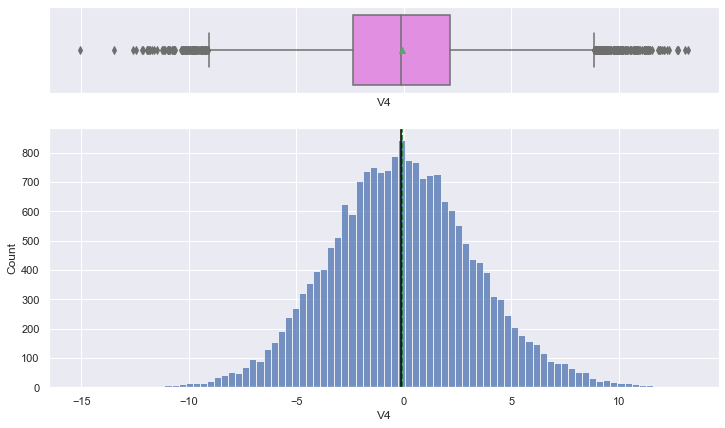

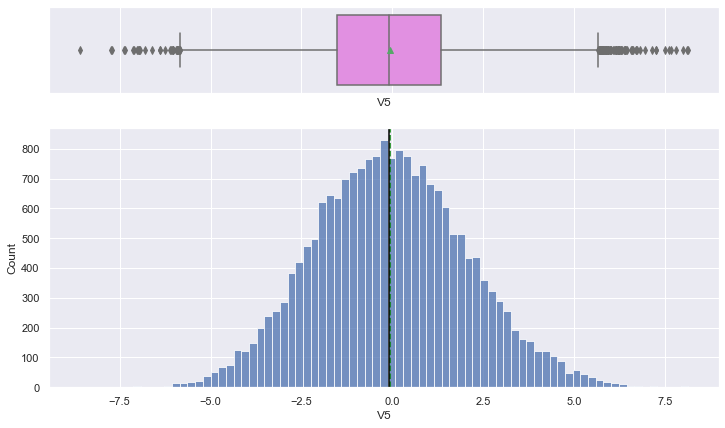

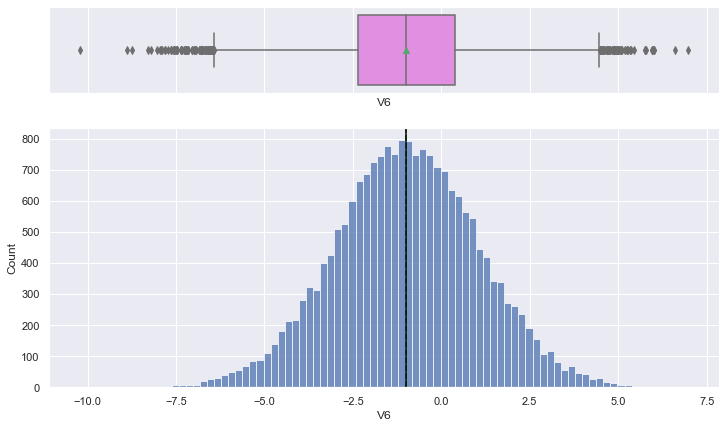

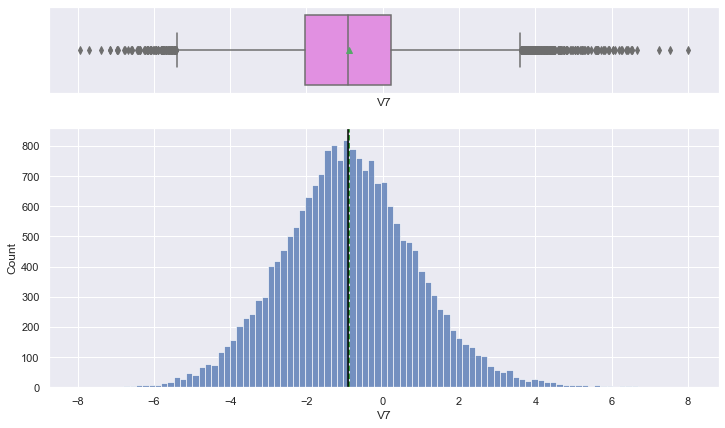

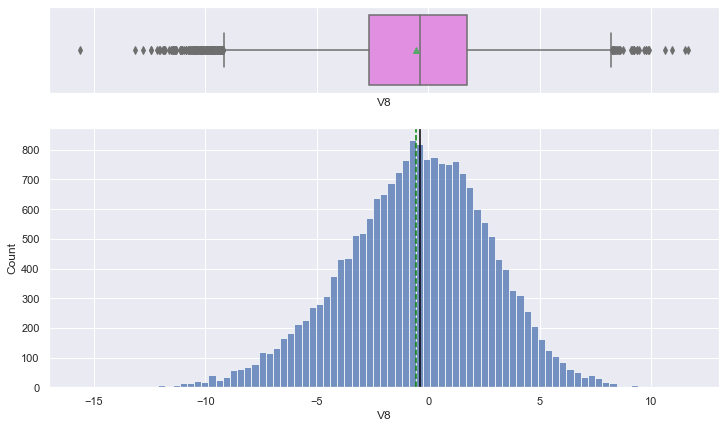

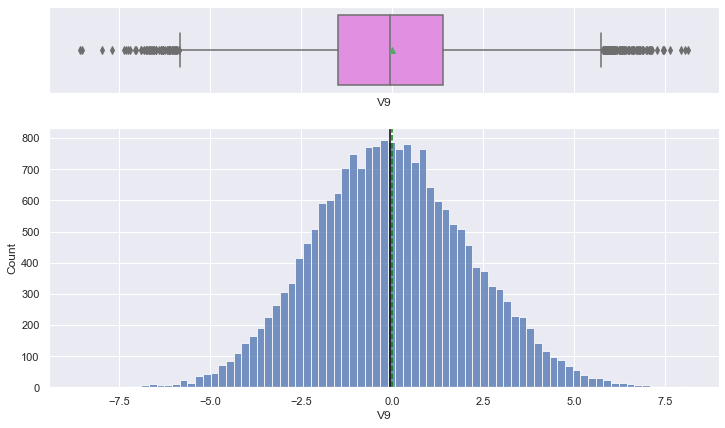

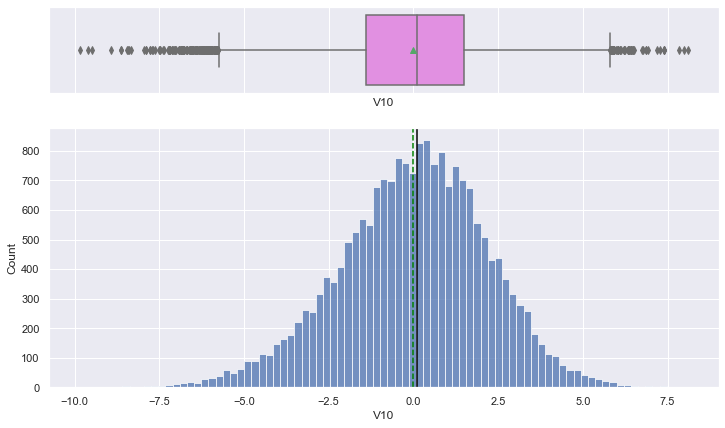

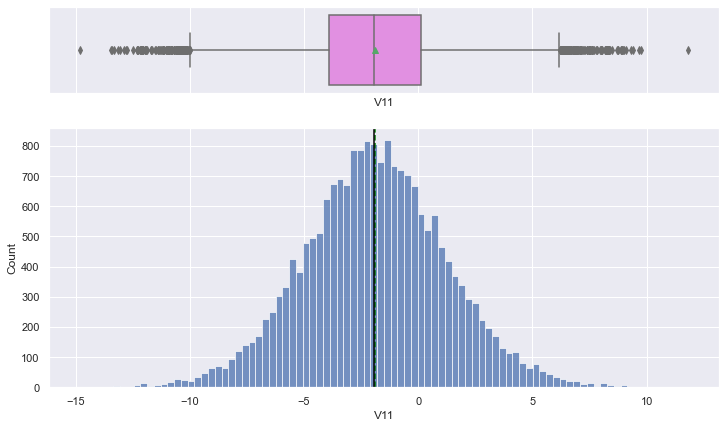

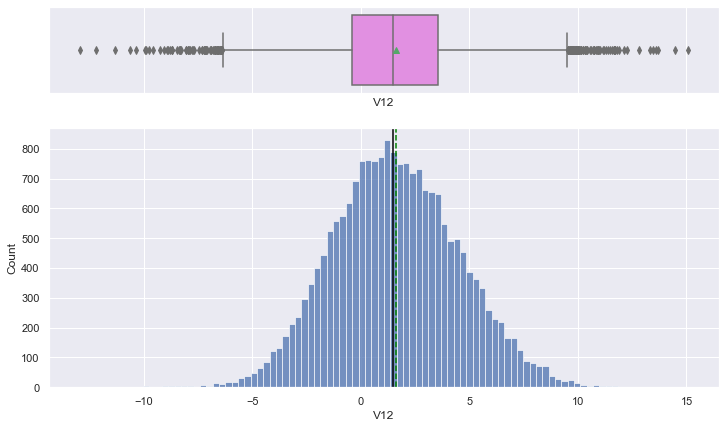

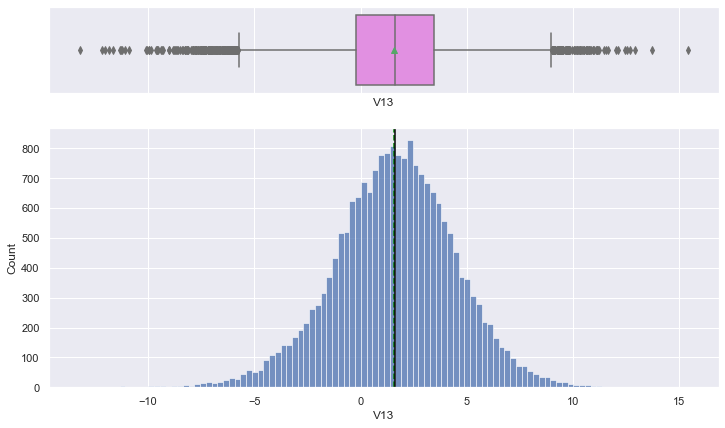

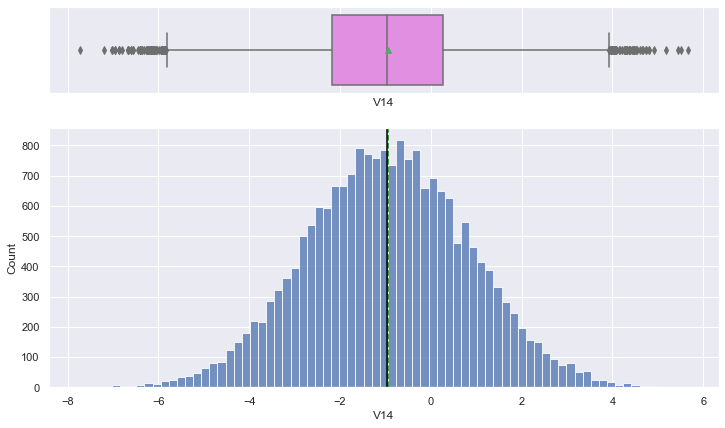

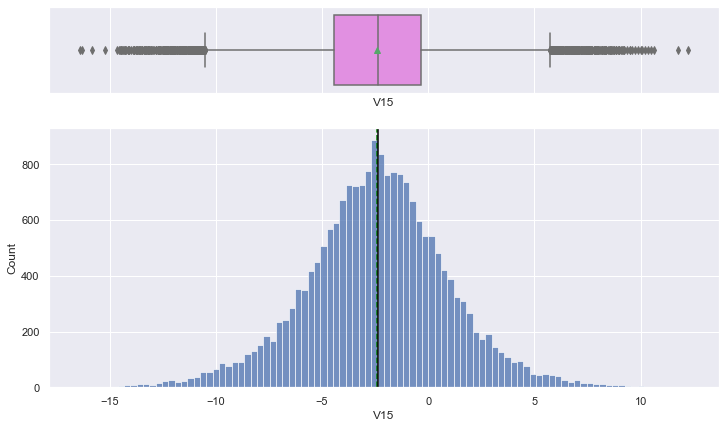

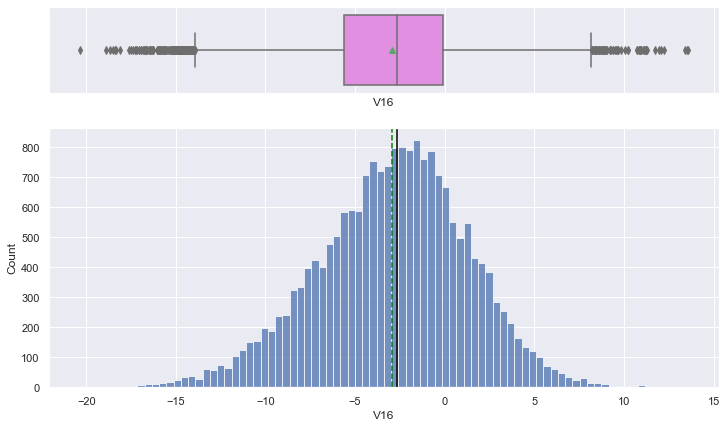

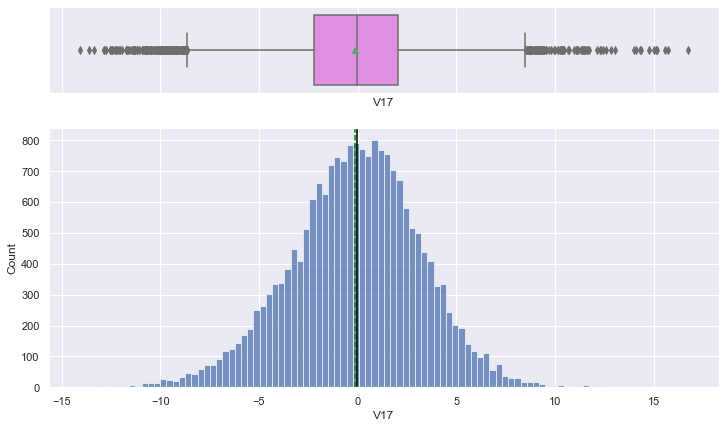

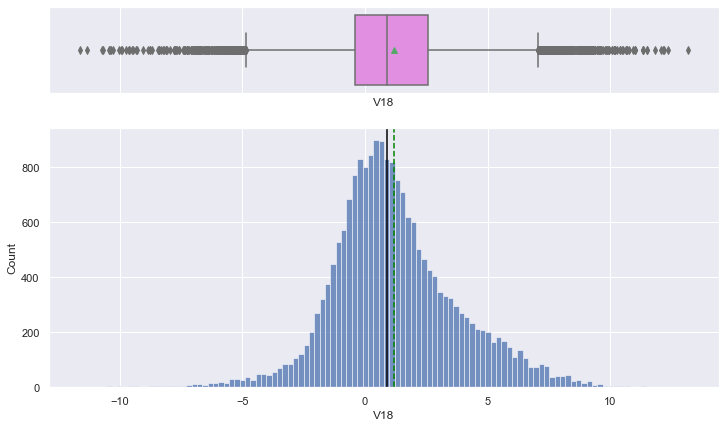

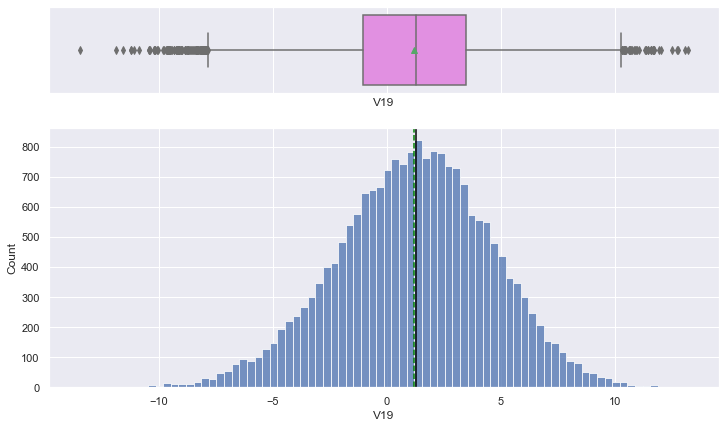

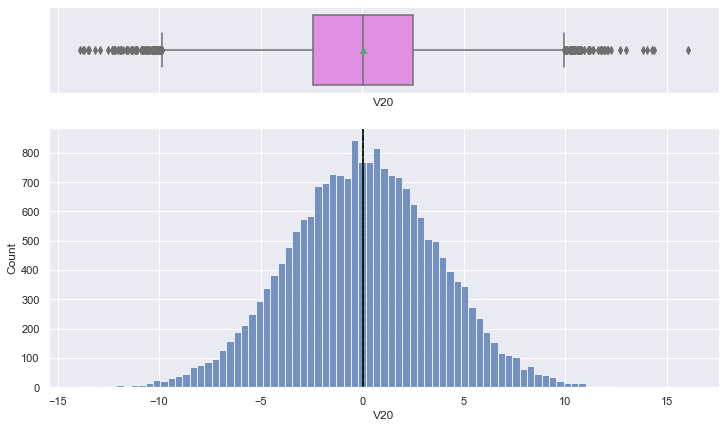

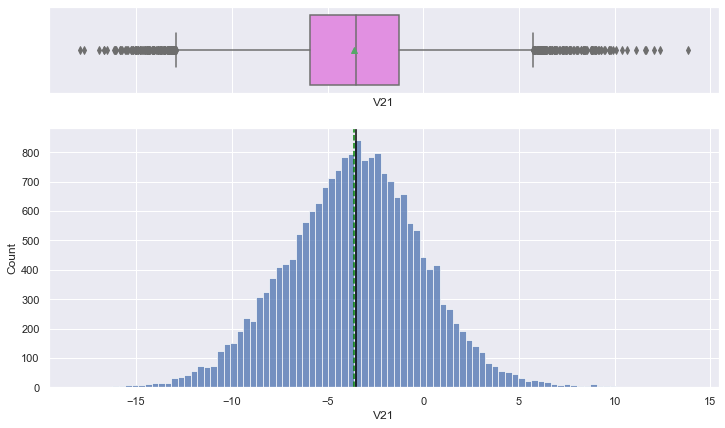

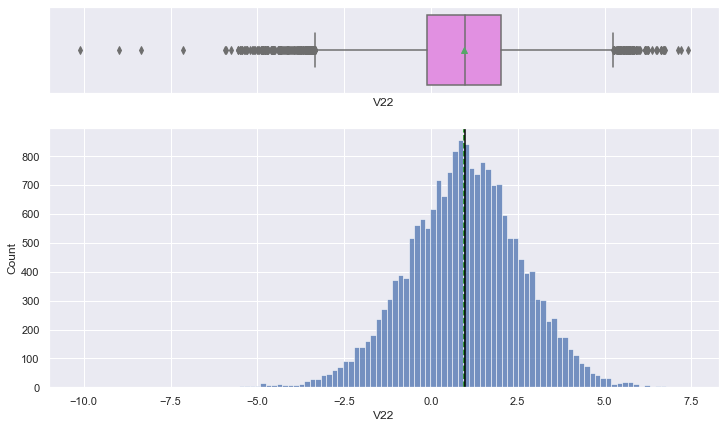

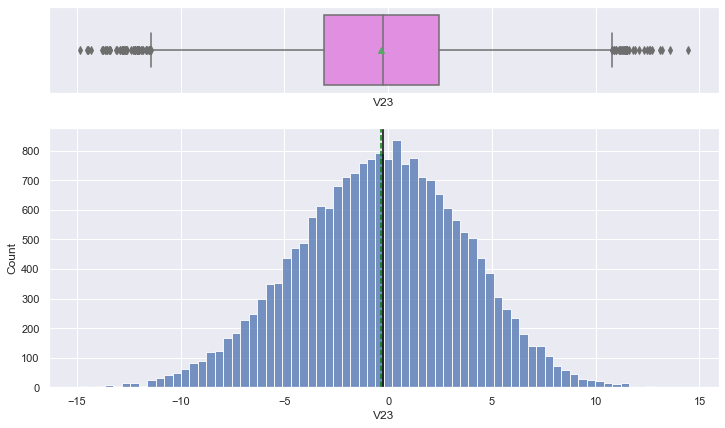

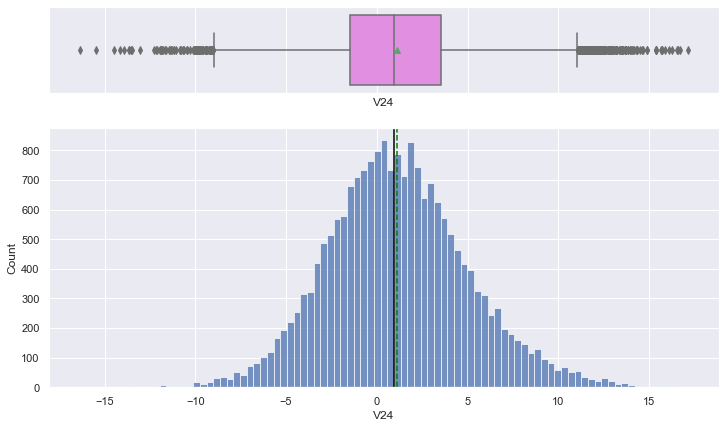

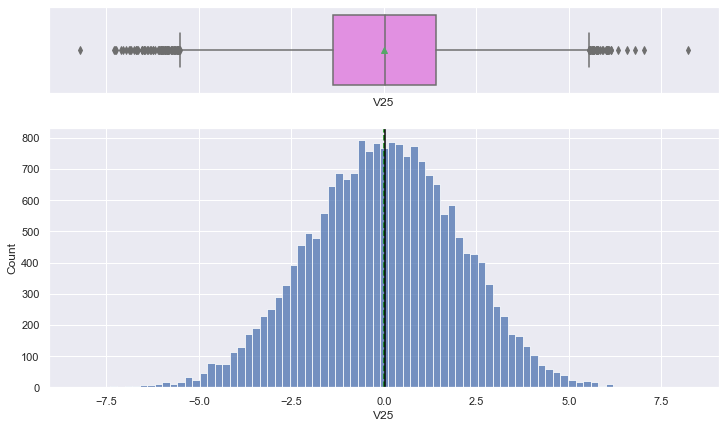

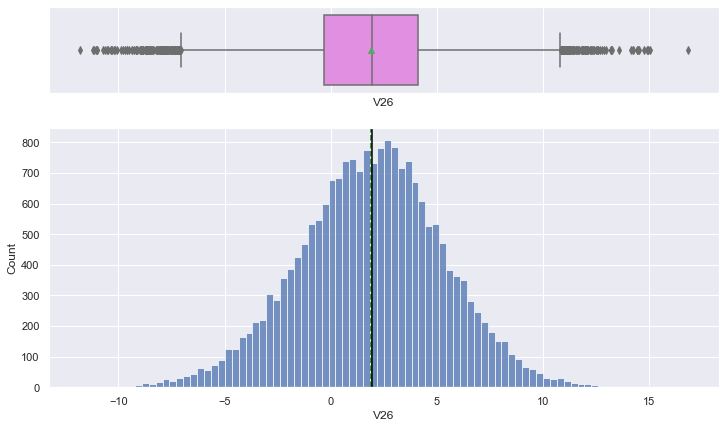

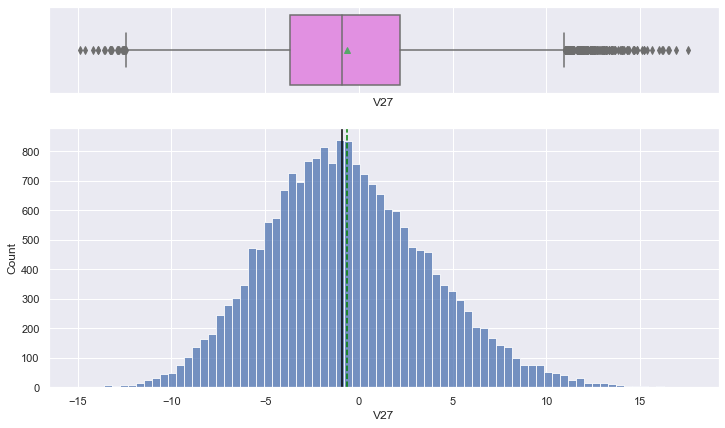

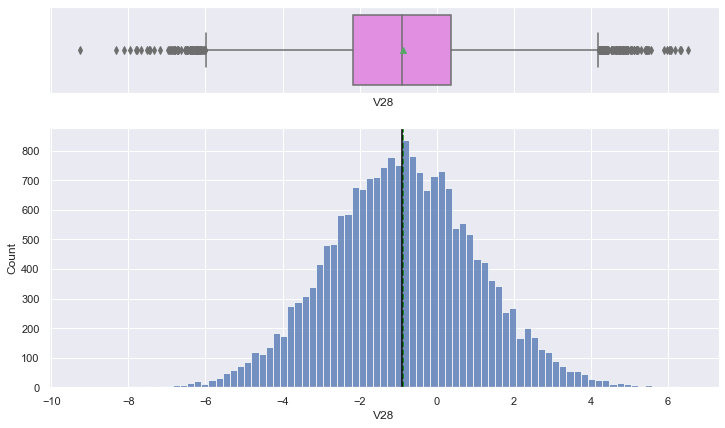

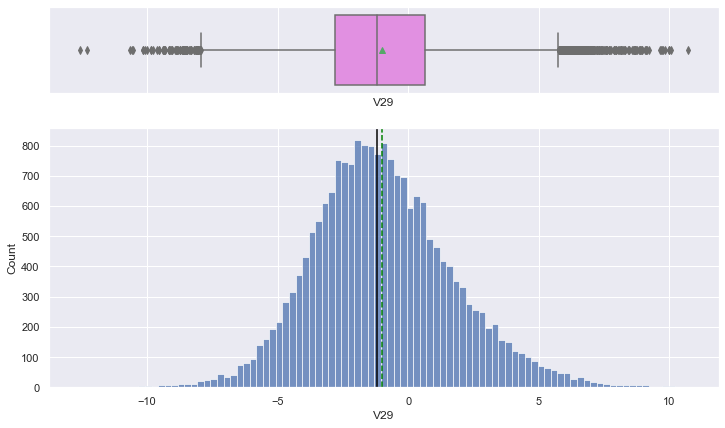

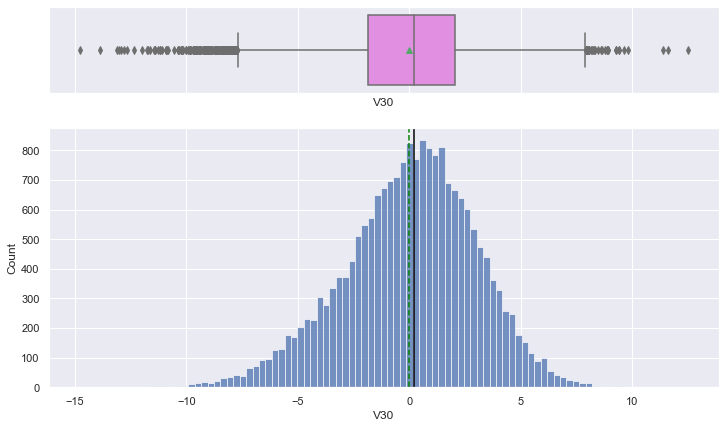

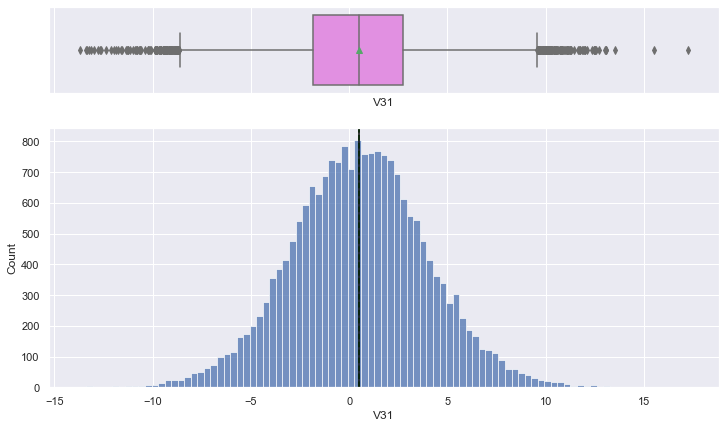

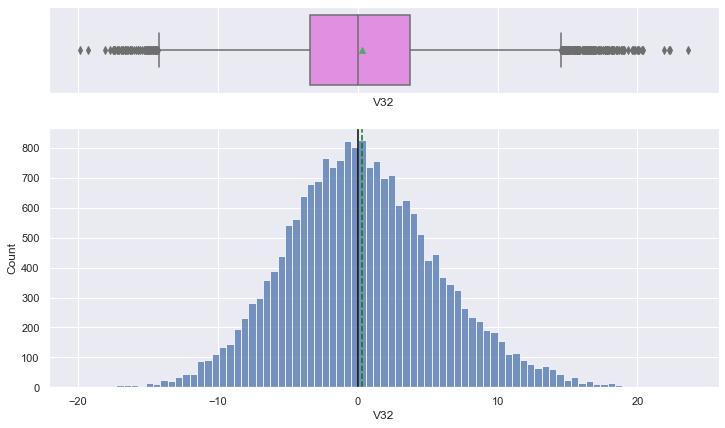

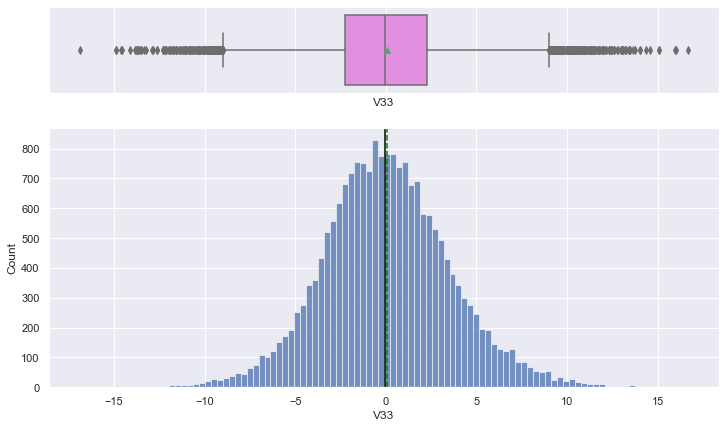

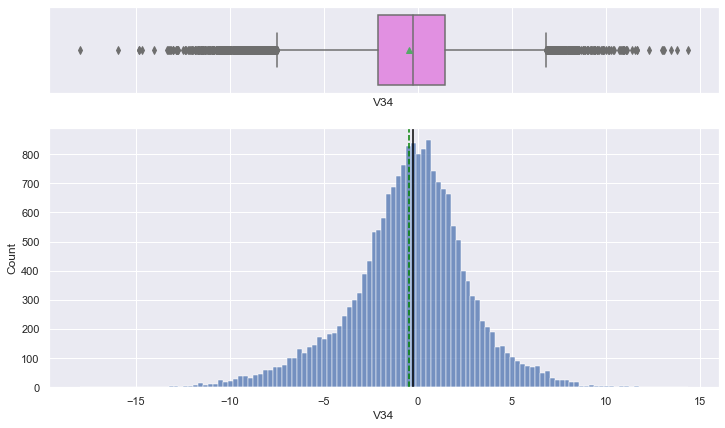

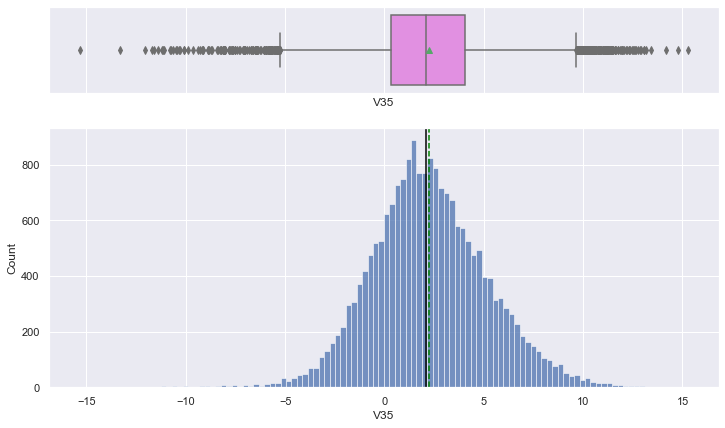

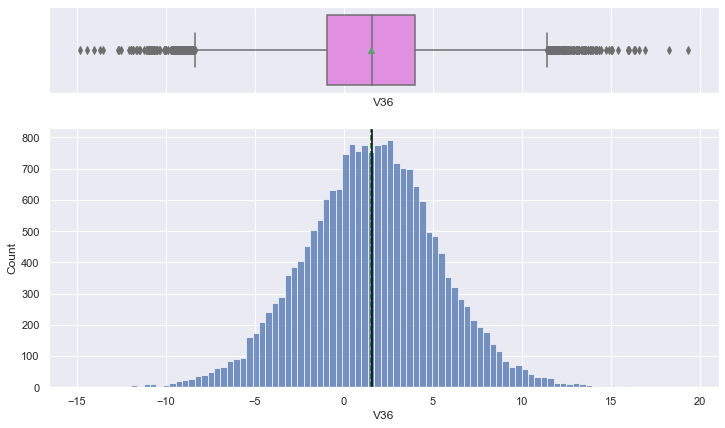

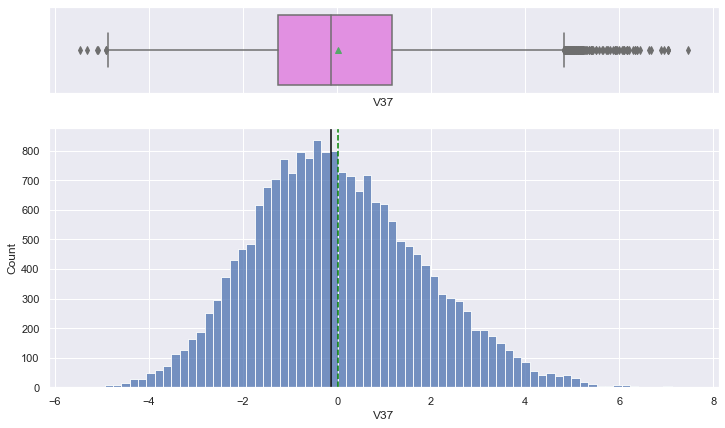

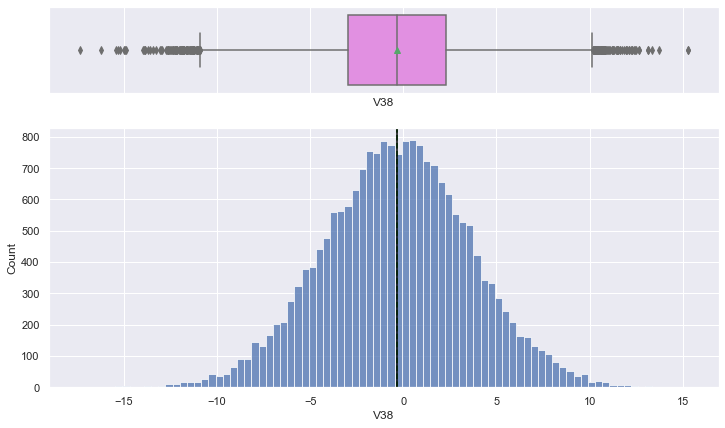

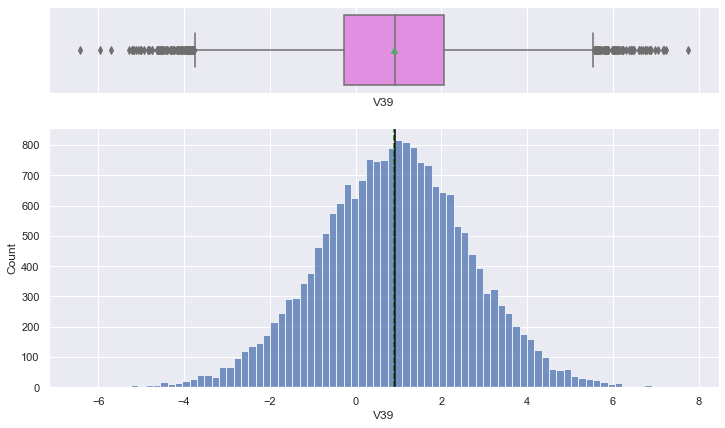

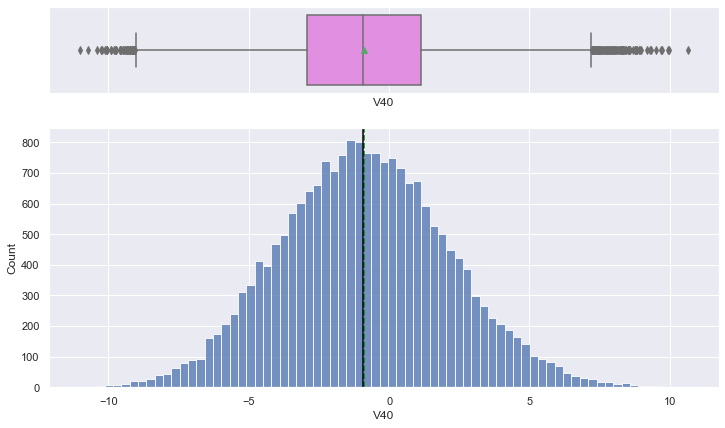

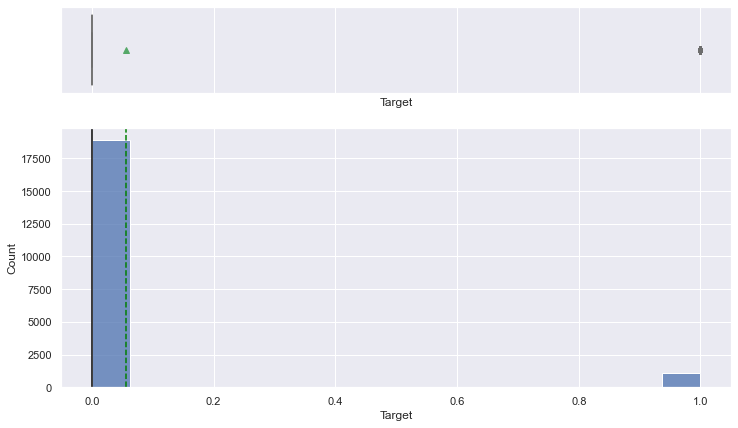

<IPython.core.display.Javascript object>

In [15]:
for feature in df.columns:
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None)

- The distributions are close to a normal distribution

### Let's look at the values in target variable

In [16]:
# for the training set
data["Target"].value_counts(1)

0   0.945
1   0.056
Name: Target, dtype: float64

<IPython.core.display.Javascript object>

In [17]:
# for the testing set
data_test["Target"].value_counts(1)

0   0.944
1   0.056
Name: Target, dtype: float64

<IPython.core.display.Javascript object>

- The target distribution is imbalanced
- Both the target variable of the train and test data has a distribution ratio of 95:5

## Data Pre-processing

In [18]:
# Dividing train data into X and y
X = data.drop(["Target"], axis=1)
y = data["Target"]

<IPython.core.display.Javascript object>

#### We already have a separate test set, we will divide train data into train, and valiation

In [19]:
# we split the data set into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

<IPython.core.display.Javascript object>

In [20]:
y_val.value_counts(1)

0   0.945
1   0.055
Name: Target, dtype: float64

<IPython.core.display.Javascript object>

In [21]:
# Checking the number of rows and columns in the X_train data
X_train.shape

(15000, 40)

<IPython.core.display.Javascript object>

In [22]:
# Checking the number of rows and columns in the X_val data
X_val.shape

(5000, 40)

<IPython.core.display.Javascript object>

In [23]:
# Dividing test data into X_test and y_test
X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

<IPython.core.display.Javascript object>

In [24]:
# Checking the number of rows and columns in the X_test data
X_test.shape

(5000, 40)

<IPython.core.display.Javascript object>

## Missing value imputation

In [25]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

<IPython.core.display.Javascript object>

In [26]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_train.columns)

<IPython.core.display.Javascript object>

In [27]:
# Checking that no column has missing values in train set
print(X_train.isna().sum().any())

False


<IPython.core.display.Javascript object>

In [28]:
# Checking that no column has missing values in validation set
print(X_val.isna().sum().any())

False


<IPython.core.display.Javascript object>

In [29]:
# Checking that no column has missing values in test set
print(X_test.isna().sum().any())

False


<IPython.core.display.Javascript object>

- Our training and validation data has no missing values

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [30]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [31]:
# defining a confusion matrix function


def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [32]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

<IPython.core.display.Javascript object>

### Model Building with original data

Sample Decision Tree model building with original data 

In [33]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Ada Boost", AdaBoostClassifier(random_state=1)))
models.append(("gradient Boost", GradientBoostingClassifier(random_state=1)))
models.append(("XGB classifier", XGBClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.7311954404444123
Logistic regression: 0.48256980015871875
Bagging: 0.6963566842219177
Random Forest: 0.7083832335329341
Ada Boost: 0.607560782050357
gradient Boost: 0.7143568285116514
XGB classifier: 0.8007935935358199

Validation Performance:

dtree: 0.7075812274368231
Logistic regression: 0.4657039711191336
Bagging: 0.7148014440433214
Random Forest: 0.7364620938628159
Ada Boost: 0.631768953068592
gradient Boost: 0.7075812274368231
XGB classifier: 0.8014440433212996


<IPython.core.display.Javascript object>

- The Logistic regression model seems to be underfitted
- The other models seems to be generalised and performed way better than the logistic regression

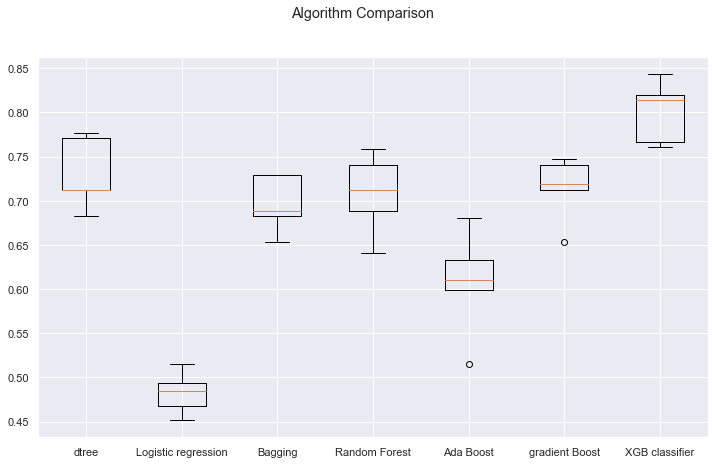

<IPython.core.display.Javascript object>

In [34]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(12, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- From the plot above, XGB classifier perfomed than others

### Model Building with Oversampled data


In [35]:
# OVERSAMPLING OUR DATA
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 833
Before OverSampling, counts of label '0': 14167 

After OverSampling, counts of label '1': 14167
After OverSampling, counts of label '0': 14167 

After OverSampling, the shape of train_X: (28334, 40)
After OverSampling, the shape of train_y: (28334,) 



<IPython.core.display.Javascript object>

In [36]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Ada Boost", AdaBoostClassifier(random_state=1)))
models.append(("gradient Boost", GradientBoostingClassifier(random_state=1)))
models.append(("XGB classifier", XGBClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# looping through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.9712006468775479
Logistic regression: 0.8797203838917327
Bagging: 0.9767064546511885
Random Forest: 0.9835533725043663
Ada Boost: 0.8992026377298903
gradient Boost: 0.9260962329994736
XGB classifier: 0.9896239027830331

Validation Performance:

dtree: 0.8194945848375451
Logistic regression: 0.851985559566787
Bagging: 0.8122743682310469
Random Forest: 0.8447653429602888
Ada Boost: 0.8483754512635379
gradient Boost: 0.8808664259927798
XGB classifier: 0.8628158844765343


<IPython.core.display.Javascript object>

- decision tree, Bagging, Random forest, and XGB classifiers did well in the validation data but the models were overfitting their training data
- Logistic Regression, Adaboost, gradient boost had a more generalised model performance with oversampled data

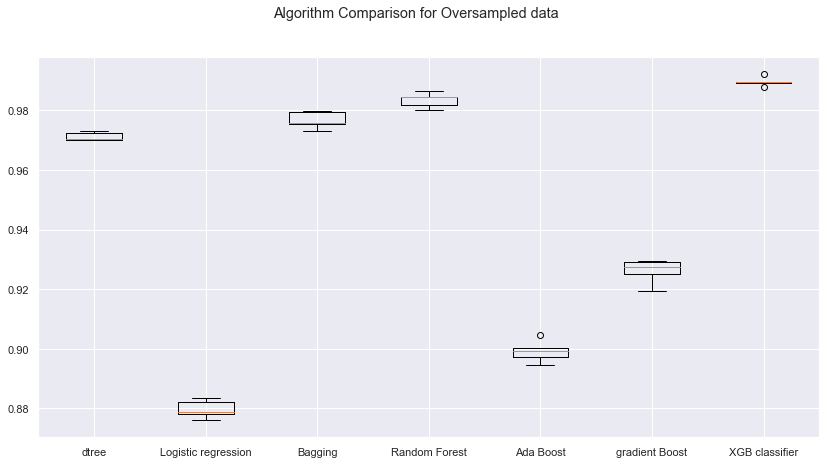

<IPython.core.display.Javascript object>

In [37]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(14, 7))

fig.suptitle("Algorithm Comparison for Oversampled data")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Again the XGB classifier performed better than the rest on the oversampled training data

### Model Building with Undersampled data

In [38]:
# Random undersampler for under sampling the data

rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 833
Before UnderSampling, counts of label '0': 14167 

After UnderSampling, counts of label '1': 833
After UnderSampling, counts of label '0': 833 

After UnderSampling, the shape of train_X: (1666, 40)
After UnderSampling, the shape of train_y: (1666,) 



<IPython.core.display.Javascript object>

In [39]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Ada Boost", AdaBoostClassifier(random_state=1)))
models.append(("gradient Boost", GradientBoostingClassifier(random_state=1)))
models.append(("XGB classifier", XGBClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.8378976985787461
Logistic regression: 0.8571026621455884
Bagging: 0.8463097900584373
Random Forest: 0.9003102229276388
Ada Boost: 0.8666762859822523
gradient Boost: 0.8931029507250559
XGB classifier: 0.8943077700021644

Validation Performance:

dtree: 0.8447653429602888
Logistic regression: 0.8736462093862816
Bagging: 0.8736462093862816
Random Forest: 0.8808664259927798
Ada Boost: 0.8736462093862816
gradient Boost: 0.8772563176895307
XGB classifier: 0.8844765342960289


<IPython.core.display.Javascript object>

- All the models gives a high recall score for nboth training and validation data.
- the models are all generalised with the undersampled data
- The random forest classifier gives the best generalisedmodel when compare to other models

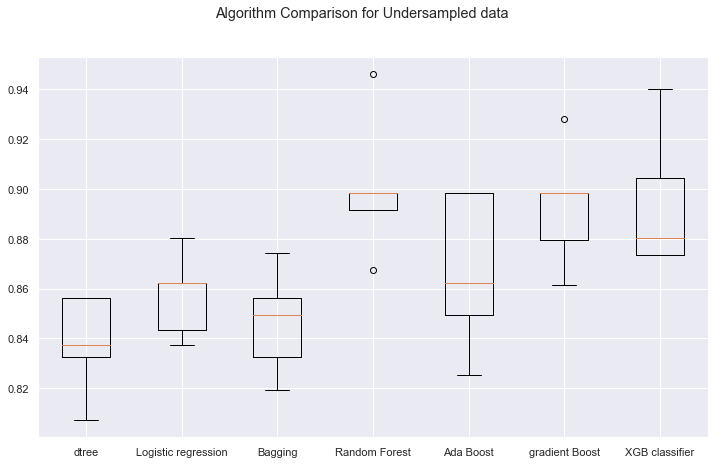

<IPython.core.display.Javascript object>

In [40]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(12, 7))

fig.suptitle("Algorithm Comparison for Undersampled data")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

#### After looking at performance of all the models, let's decide which models can further improve with hyperparameter tuning.

## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

# Tuning Decision Tree Model

### Tuning Decision tree model with oversampled data

In [41]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "max_depth": np.arange(2, 6),
    "min_samples_leaf": [1, 4, 7],
    "max_leaf_nodes": [10, 15],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9169896030775508:


<IPython.core.display.Javascript object>

In [42]:
# choosing the best estimator as the model
dtree_tuned_over = randomized_cv.best_estimator_

# fitting the model with the best estimator
dtree_tuned_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       random_state=1)

<IPython.core.display.Javascript object>

In [43]:
# Checking the performance of model on training data
dtree_tuned_train_over_perf = model_performance_classification_sklearn(
    dtree_tuned_over, X_train_over, y_train_over
)
dtree_tuned_train_over_perf

,Accuracy,Recall,Precision,F1
0,0.846,0.915,0.804,0.856


<IPython.core.display.Javascript object>

In [44]:
# Checking the performance of model on validation data
dtree_tuned_val_over_perf = model_performance_classification_sklearn(
    dtree_tuned_over, X_val, y_val
)
dtree_tuned_val_over_perf

,Accuracy,Recall,Precision,F1
0,0.778,0.870,0.183,0.303


<IPython.core.display.Javascript object>

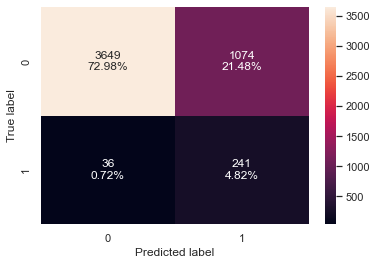

<IPython.core.display.Javascript object>

In [45]:
# Creating the confusion matrix
confusion_matrix_sklearn(dtree_tuned_over, X_val, y_val)

- The recall for both training and validation is high
- This model is generalised
- The validation recall is 87% i.e. the model  will do well at identifying failures
- The precision accuracy is poor, meaning that model will also identify many non failures as failures

# Tuning Logistic Regression Model

### Tuning Logistic Regression model with oversampled data

In [46]:
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"C": np.arange(0.1, 1.1, 0.1)}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'C': 0.1} with CV score=0.87929770142745:


<IPython.core.display.Javascript object>

In [47]:
# choosing the best estimator as the model
lr_tuned_over = randomized_cv.best_estimator_

# fitting the model with the best estimator
lr_tuned_over.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1, random_state=1)

<IPython.core.display.Javascript object>

In [48]:
# Checking the performance of model on training data
lr_tuned_train_over_perf = model_performance_classification_sklearn(
    lr_tuned_over, X_train_over, y_train_over
)
lr_tuned_train_over_perf

,Accuracy,Recall,Precision,F1
0,0.876,0.880,0.874,0.877


<IPython.core.display.Javascript object>

In [49]:
# Checking the performance of model on validation data
lr_tuned_val_over_perf = model_performance_classification_sklearn(
    lr_tuned_over, X_val, y_val
)
lr_tuned_val_over_perf

,Accuracy,Recall,Precision,F1
0,0.876,0.852,0.289,0.431


<IPython.core.display.Javascript object>

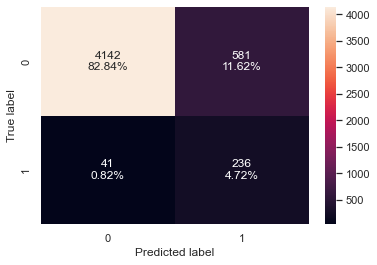

<IPython.core.display.Javascript object>

In [50]:
# Creating the confusion matrix
confusion_matrix_sklearn(lr_tuned_over, X_val, y_val)

- The model is generalised and has performed well with respect to recall score
- The precision score for the validation data is poor

# Tuning Bagging Model

### Tuning Bagging model with oversampled data

In [51]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "max_samples": [0.8, 0.9, 1],
    "max_features": [0.7, 0.8, 0.9],
    "n_estimators": [30, 50, 70],
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.7} with CV score=0.982917928905746:


<IPython.core.display.Javascript object>

In [52]:
# choosing the best estimator as the model
BGC_tuned_over = randomized_cv.best_estimator_

# fitting the model with the best estimator
BGC_tuned_over.fit(X_train_over, y_train_over)

BaggingClassifier(max_features=0.7, max_samples=0.9, n_estimators=70,
                  random_state=1)

<IPython.core.display.Javascript object>

In [53]:
# Checking the performance of model on training data
BGC_tuned_train_over_perf = model_performance_classification_sklearn(
    BGC_tuned_over, X_train_over, y_train_over
)
BGC_tuned_train_over_perf

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


<IPython.core.display.Javascript object>

In [54]:
# Checking the performance of model on validation data
BGC_tuned_val_over_perf = model_performance_classification_sklearn(
    BGC_tuned_over, X_val, y_val
)
BGC_tuned_val_over_perf

,Accuracy,Recall,Precision,F1
0,0.987,0.856,0.908,0.881


<IPython.core.display.Javascript object>

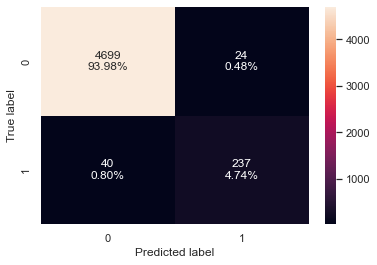

<IPython.core.display.Javascript object>

In [55]:
# Creating the confusion matrix
confusion_matrix_sklearn(BGC_tuned_over, X_val, y_val)

- Just like the model before this, this model also overfit the training data

# Tuning Random Forest Model

### Tuning Random Forest model with oversampled data

In [56]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200, 250, 300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1), "sqrt"],
    "max_samples": np.arange(0.4, 0.7, 0.1),
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9817177877126646:


<IPython.core.display.Javascript object>

In [57]:
# choosing the best estimator as the model
RF_tuned_over = randomized_cv.best_estimator_

# fitting the model with the best estimator
RF_tuned_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_samples=0.6, n_estimators=200, random_state=1)

<IPython.core.display.Javascript object>

In [58]:
# Checking the performance of model on training data
RF_tuned_over_train_perf = model_performance_classification_sklearn(
    RF_tuned_over, X_train_over, y_train_over
)
RF_tuned_over_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


<IPython.core.display.Javascript object>

In [59]:
# Checking the performance of model on validation data
RF_tuned_over_val_perf = model_performance_classification_sklearn(
    RF_tuned_over, X_val, y_val
)
RF_tuned_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.988,0.845,0.936,0.888


<IPython.core.display.Javascript object>

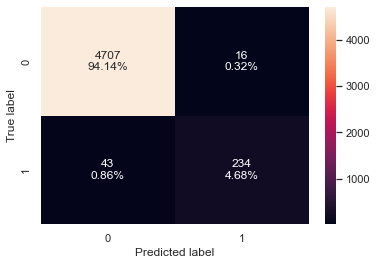

<IPython.core.display.Javascript object>

In [60]:
# Creating the confusion matrix
confusion_matrix_sklearn(RF_tuned_over, X_val, y_val)

- Again we have an overfit model

# Tuning AdaBoost Model

### Tuning AdaBoost model with oversampled data

In [61]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9716945984678509:


<IPython.core.display.Javascript object>

In [62]:
# choosing the best estimator as the model
ABC_tuned_over = randomized_cv.best_estimator_

# fitting the model with the best estimator
ABC_tuned_over.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

<IPython.core.display.Javascript object>

In [63]:
# Checking the performance of model on training data
ABC_tuned_over_train_perf = model_performance_classification_sklearn(
    ABC_tuned_over, X_train_over, y_train_over
)
ABC_tuned_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.990,0.985,0.996,0.990


<IPython.core.display.Javascript object>

In [64]:
# Checking the performance of model on validation data
ABC_tuned_over_val_perf = model_performance_classification_sklearn(
    ABC_tuned_over, X_val, y_val
)
ABC_tuned_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.982,0.863,0.818,0.840


<IPython.core.display.Javascript object>

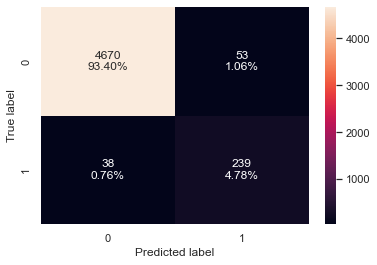

<IPython.core.display.Javascript object>

In [65]:
# Creating the confusion matrix
confusion_matrix_sklearn(ABC_tuned_over, X_val, y_val)

- The model is slightly oerfitting the training data
- We have seen better models than this

# Tuning Gradient Boosting Model

### Tuning Gradient Boosting model with oversampled data

In [66]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100, 150, 25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7],
}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 1} with CV score=0.9666126439550405:


<IPython.core.display.Javascript object>

In [67]:
# choosing the best estimator as the model
GBC_tuned_over = randomized_cv.best_estimator_

# fitting the model with the best estimator
GBC_tuned_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.7, n_estimators=125,
                           random_state=1, subsample=0.7)

<IPython.core.display.Javascript object>

In [68]:
# Checking the performance of model on training data
GBC_tuned_over_train_perf = model_performance_classification_sklearn(
    GBC_tuned_over, X_train_over, y_train_over
)
GBC_tuned_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.992,0.991,0.992,0.992


<IPython.core.display.Javascript object>

In [69]:
# Checking the performance of model on validation data
GBC_tuned_over_val_perf = model_performance_classification_sklearn(
    GBC_tuned_over, X_val, y_val
)
GBC_tuned_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.969,0.845,0.674,0.750


<IPython.core.display.Javascript object>

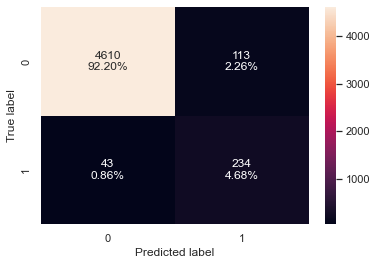

<IPython.core.display.Javascript object>

In [70]:
# Creating the confusion matrix
confusion_matrix_sklearn(GBC_tuned_over, X_val, y_val)

- Althoght the recall score is high in validation data, the model is an overfit so will not be used as the final model

# Tuning XGBoost Model

### Tuning XGBoost model using undersampled data

In [71]:
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [150, 200, 250],
    "scale_pos_weight": [5, 10],
    "learning_rate": [0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.8, 0.9],
}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.9243993939831181:


<IPython.core.display.Javascript object>

In [72]:
# choosing the best estimator as the model
XGB_tuned_under = randomized_cv.best_estimator_

# fitting the model with the best estimator
XGB_tuned_under.fit(X_train_un, y_train_un)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [73]:
# Checking the performance of model on training data
XGB_tuned_under_train_perf = model_performance_classification_sklearn(
    XGB_tuned_under, X_train_un, y_train_un
)
XGB_tuned_under_train_perf

,Accuracy,Recall,Precision,F1
0,0.998,1.000,0.996,0.998


<IPython.core.display.Javascript object>

In [74]:
# Checking the performance of model on validation data
XGB_tuned_under_val_perf = model_performance_classification_sklearn(
    XGB_tuned_under, X_val, y_val
)
XGB_tuned_under_val_perf

,Accuracy,Recall,Precision,F1
0,0.879,0.910,0.303,0.454


<IPython.core.display.Javascript object>

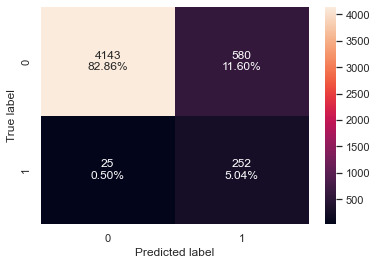

<IPython.core.display.Javascript object>

In [75]:
# Creating the confusion matrix
confusion_matrix_sklearn(XGB_tuned_under, X_val, y_val)

- The model is good but the decision tree model tuned with oversampled data will perform better in production that it

**We have now tuned all the models, let's compare the performance of all tuned models and see which one is the best.**

## Model performance comparison and choosing the final model

In [76]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        dtree_tuned_train_over_perf.T,
        lr_tuned_train_over_perf.T,
        BGC_tuned_train_over_perf.T,
        RF_tuned_over_train_perf.T,
        ABC_tuned_over_train_perf.T,
        GBC_tuned_over_train_perf.T,
        XGB_tuned_under_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision tree tuned with oversampled data",
    "Logistic Regression tuned with oversampled data",
    "Bagging tuned with oversampled data",
    "Random Forest tuned with oversampled data",
    "AdaBoost tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "XGBoost tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df.T

Training performance comparison:


,Accuracy,Recall,Precision,F1
Decision tree tuned with oversampled data,0.846,0.915,0.804,0.856
Logistic Regression tuned with oversampled data,0.876,0.880,0.874,0.877
Bagging tuned with oversampled data,1.000,1.000,1.000,1.000
Random Forest tuned with oversampled data,1.000,1.000,1.000,1.000
AdaBoost tuned with oversampled data,0.990,0.985,0.996,0.990
Gradient Boosting tuned with oversampled data,0.992,0.991,0.992,0.992
XGBoost tuned with undersampled data,0.998,1.000,0.996,0.998


<IPython.core.display.Javascript object>

In [77]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        dtree_tuned_val_over_perf.T,
        lr_tuned_val_over_perf.T,
        BGC_tuned_val_over_perf.T,
        RF_tuned_over_val_perf.T,
        ABC_tuned_over_val_perf.T,
        GBC_tuned_over_val_perf.T,
        XGB_tuned_under_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Decision tree tuned with oversampled data",
    "Logistic Regression tuned with oversampled data",
    "Bagging tuned with oversampled data",
    "Random Forest tuned with oversampled data",
    "AdaBoost tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "XGBoost tuned with undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df.T

Validation performance comparison:


,Accuracy,Recall,Precision,F1
Decision tree tuned with oversampled data,0.778,0.870,0.183,0.303
Logistic Regression tuned with oversampled data,0.876,0.852,0.289,0.431
Bagging tuned with oversampled data,0.987,0.856,0.908,0.881
Random Forest tuned with oversampled data,0.988,0.845,0.936,0.888
AdaBoost tuned with oversampled data,0.982,0.863,0.818,0.840
Gradient Boosting tuned with oversampled data,0.969,0.845,0.674,0.750
XGBoost tuned with undersampled data,0.879,0.910,0.303,0.454


<IPython.core.display.Javascript object>

In [78]:
# merging the training and validation recalls of all the models for easy comparison
Train_val_Recall_df = pd.concat(
    [models_train_comp_df.loc["Recall"].T, models_val_comp_df.loc["Recall"].T], axis=1
)
Train_val_Recall_df.columns = ["Training_Recall", "Validation_Recall"]
Train_val_Recall_df

,Training_Recall,Validation_Recall
Decision tree tuned with oversampled data,0.915,0.870
Logistic Regression tuned with oversampled data,0.880,0.852
Bagging tuned with oversampled data,1.000,0.856
Random Forest tuned with oversampled data,1.000,0.845
AdaBoost tuned with oversampled data,0.985,0.863
Gradient Boosting tuned with oversampled data,0.991,0.845
XGBoost tuned with undersampled data,1.000,0.910


<IPython.core.display.Javascript object>

- From the above model, the best and most generalised model is the **Decision tree tuned with oversampled data** with a training recall score of 91.5% and a validation recall score of 87%
- I will adopt this model as my final model as I progress

### Test set final performance

In [79]:
# defining our final model
final_model = dtree_tuned_over

# Checking the performance of model on test data
final_model_test_perf = model_performance_classification_sklearn(
    final_model, X_test, y_test
)
final_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.798,0.840,0.198,0.320


<IPython.core.display.Javascript object>

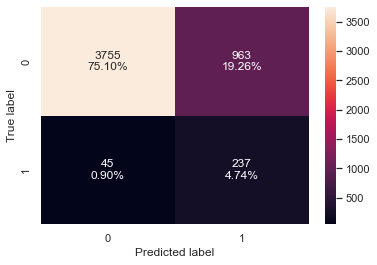

<IPython.core.display.Javascript object>

In [80]:
# Creating the confusion matrix
confusion_matrix_sklearn(final_model, X_test, y_test)

### Feature Importances

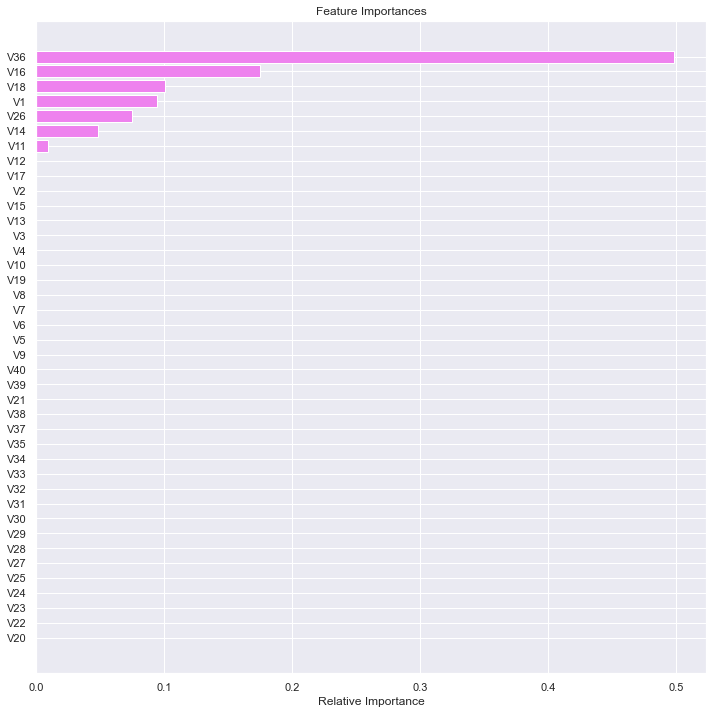

<IPython.core.display.Javascript object>

In [81]:
# Visualising the most imoportant features
feature_names = X_train.columns
importances = final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Pipelines to build the final model


### Pipelines for productionizing the model

- Now, we have a final model. let's use pipelines to put the model into production

In [82]:
# creating pipeline for the best model
Pipeline_model = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("model", final_model)]
)

<IPython.core.display.Javascript object>

In [83]:
# Separating target variable and other variables
X1 = df.drop(columns="Target")
Y1 = df["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test
X_test1 = df_test.drop(columns="Target")
y_test1 = df_test["Target"]

<IPython.core.display.Javascript object>

- Since the best and final model is built on the oversampled data,  I will perform oversampling based on that.
- Before over sampling i will handle the missing values

In [84]:
# doing missing value treatment before oversampling data
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# We don't need to impute missing values in test set as it will be done inside pipeline

<IPython.core.display.Javascript object>

In [85]:
# oversampling the data
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

<IPython.core.display.Javascript object>

In [86]:
# fitting the Pipeline Model
Pipeline_model.fit(X_over1, y_over1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15,
                                        min_impurity_decrease=0.001,
                                        min_samples_leaf=7, random_state=1))])

<IPython.core.display.Javascript object>

In [87]:
# Checking the performance of model on test data
Pipeline_model_test = model_performance_classification_sklearn(
    Pipeline_model, X_test1, y_test1
)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.786,0.844,0.188,0.308


<IPython.core.display.Javascript object>

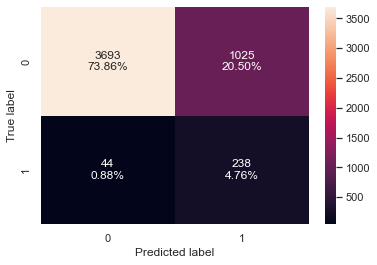

<IPython.core.display.Javascript object>

In [88]:
# Creating the confusion matrix
confusion_matrix_sklearn(Pipeline_model, X_test1, y_test1)

# Business Insights and Conclusions

- Most of the models with high validation recall values were slightly overfiiting the training data.
- The best model is the **Decision tree model tuned with oversampled data**.
    - it is the best generalised model of all the models
    - Its has a training recall value of 91.5%, a validation recall value of 87% and a test recall value of 84.4%
    - This implies that the final model can correctly predict failures of machine by 84.4%
- The model shows a precision value of 18.8% on the test data meaning the model has a high chance of detecting failure in a generator where there is actually no failure hence increasing the inspection cost.
- The model performance can be improved, especially in terms of precision.
- The most important Features are the **V36, V18, V16**
    - These important features must be taken into consideraton as the cost of repairing a generator and the cost of the inspection  are much less than the cost of replacing it, . 
- The model will help us Identify the failures before they occur hence saving the company replacement cost.

***

# THE END !!!